# Convolutional Neural Network Code

This Notebook is where we will create and fit the CNN model for the project.

This project uses a lot of compute power and to be more efficient, I needs to run on AWS instance. And even using a powerful machine, it took quite a long time to be able to fit a decent model.

On the next steps, I'll go through the necessary steps to make to make it happen.

## Dataset

I was luck enought to find a Dataset in Kaggle that was trying to approach the same problem as I am with this project.

Here is the link for the challenge and to my dataset: https://www.kaggle.com/c/state-farm-distracted-driver-detection

The first step was to upload the dataset to Amazon SageMaker. The steps are simple:

1- Upload the zip file with all images to AWS</br>
2- Unzip</br>

The code bellow runs `terminal` code directly on teh Notebook. It is commented out so I don't accidently run it again and have everything replaced.

In [1]:
# COMMENT: Activate bash commands
# %%bash
# COMMENT: Unzip file with images
# unzip -qo imgs.zip

## Import Necessary Libraries

In [3]:
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Conv3D, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import MobileNet, VGG16, InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.optimizers import Adam

Using TensorFlow backend.


## Defining global variables

Duting the execution of the code, I'll be needing a few `Global` variables that will help me out making everything the same. I'll define those codes bellow:

In [4]:
# Defining original images size
init_img_height = 480
init_img_width = 640

#Define a Rescale Factor
rescale_factor = 1

# Defining new resized image size
img_height = int(init_img_height/rescale_factor)
img_width = int(init_img_width/rescale_factor)

# Defining batch size for CNN to work on
batch_size = 32

# Defining number of classes in the project
num_classes = 10

## Defining CNN MOdel, Transfer Learning and Fully Connected Layers

In [5]:
# Instantiating MobileNet as the chosen Transfer Learning Network
base_model = MobileNet(weights='imagenet', include_top=False)

# Transfer Learning has many Layers on it. The code bellow captures the result of all those layers
x = base_model.output

# Applying my Custom Neural Network

# Applying Global Average Pooling
x = GlobalAveragePooling2D()(x)
# Applying Dropout to avoid Overfitting
x = Dropout(0.3)(x)

# Applying Dense of 2000
x = Dense(2000, activation='relu')(x) 
# Applying Dropout to avoid Overfitting
x = Dropout(0.5)(x)

# Applying Dense of 500. Decreasing the number of Nodes in the Layers
x = Dense(500, activation='relu')(x)
# Applying Dropout to avoid Overfitting
x = Dropout(0.5)(x)

# Applying Dense of 10 (Number os classes) and add Softmax Layer to finish it off
preds = Dense(num_classes, activation='softmax')(x)

# Instantiating the final Model with all necessary Layers
model = Model(inputs = base_model.input, outputs = preds)

# Getting the Summary of the Network
model.summary()














87916544/87910968 [==============================] - 12s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (

## Defining Trainable Layers

I am using Transfer Learning because it is a widely used Network to use on images. Since it is already trained for many applications, I decided to make is `un-trainable`. With that, I can optimize my model and run it faster.

The `Fully Connected Layers` will trainable.

Basically, the Convolutional Layers from MobileNet are transforming each image in something that can be easily read by the Machine and my layers are working to get my classifications.

In [6]:
# Deactivateing Learning for all 87 first layers
for layer in model.layers[:312]:
    layer.trainable=False
# Activating Learning for the remaining layers
for layer in model.layers[312:]:
    layer.trainable=True

## Creating Train and test Data Generators for Keras

`Keras` has a very helpfull function call Data Generators. I realied a lot on those to make my code run faster.

### First:Instantiate Image Data Generators

In [7]:
# Instantiate ImageDataGenerator for Train and validation
# For my problem I decided to only rescale and Zoom the images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    validation_split=0.2) # I am also using this parameter to split the Train in Train and Validation Sets

In [8]:
# Instantiate ImageDataGenerator for Test
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rescale=1./255)

### Second: scan directories with images and apply transformations

Data Generators on Keras has a very handy function called `flow_from_directory`. This function scans a specific folder (in my case `/train`) and it searches for a subset of folders inside of it. Those will be the `classes` labels and every image inside it will be the images for that specific class.

The image bellow shows how the folder are being used.


<img src="flow_from_directory Image.png">

Bellow we cann see 10 classes (c0 to c9) and inside each class, their respective images

In [9]:
# Using Data Generators to scan Train folder and get back the Classes and Images as a Generator (not Iterator)
train_generator = train_datagen.flow_from_directory(
    directory='data/imgs/train/', # The folder to be scanned
    target_size=(img_height, img_width), # Images size
    color_mode="rgb", # Images color dimensions
    batch_size=batch_size, # Batch size
    class_mode="categorical", #Classification problem
    shuffle=True, #randomizer
    subset='training' # Here I define the Subset as being the Train set
)

# Using Data Generators to scan Train folder and get back the Classes and Images as a Generator (not Iterator)
validation_generator = train_datagen.flow_from_directory(
    directory='data/imgs/train/', # The folder to be scanned
    target_size=(img_height, img_width), # Images size
    color_mode="rgb",# Images color dimensions
    batch_size=batch_size,# Batch size
    class_mode="categorical", #Classification problem
    shuffle=True, #randomizer
    subset='validation', # Here I define the Subset as being the Validation set
    
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


## Checking to see if everything is fine on the Images Generator.

This little code, provided by Mirwan, help me out debug the Major problem I had with my project. I was switching Height and Width on the Train Set and when I passed it to the Test Set (which had the sizes correct), the model wasn't being able to predict correclty. With this code, I was able to see the problem and fix it in time to deliver my project.

So, Kudos to Mirwan :)

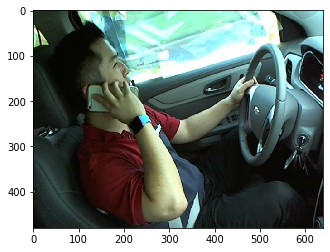

In [11]:
import matplotlib.pyplot as plt
# Get Next batch of images from generator
x,_ = train_generator.next()
plt.figure()
# Plot the very first image from the Generator
plt.imshow(x[0])
plt.show()

### Check for all classes detected

In [12]:
label_map = train_generator.class_indices
label_map

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

## Compile Model

In [13]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Define Step Size for Train. Since I am using Generators for my Images, I'll need to use `fit_generator` function on the Model Instance and ofr that I need to define a Step_size

In [15]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_train

560

Finally, I'll add Callbacks so my model can stop earlier if necessary

In [16]:
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1, min_delta=0.0000001)
reduceRL = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.001, min_delta=0.0001, verbose=1,
                             min_lr=1e-6)
callbacks = [earlyStop, reduceRL] 

Fit the Model and put it on a Histoty variable.

In [ ]:
history = model.fit_generator(generator = train_generator, 
                    steps_per_epoch = step_size_train, 
                    epochs = 50,
                    callbacks=callbacks)

Epoch 1/50
203/560 [=========>....................] - ETA: 1:44:45 - loss: 2.4141 - acc: 0.1108

### Saving Model in /Saved_models folder

In [ ]:
import time

# Define Directory Path
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Define timestamp value. Taht way I don't need to replace previous models
time_str = time.strftime('%Y%m%d-%H%M',time.localtime())

# Defining Model Name
model_name = f'{time_str}_epochs.h5'

# Make Directory if it doesn't exists
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
# Save model
model.save(model_path)
print('Saved trained model at %s ' % model_path)

### Load Model from /Saved_models folder

In [2]:
# Load prevous model in case the notebook instance has restarted
model = load_model('saved_models/20191207-0450_epochs.h5')












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




### Evaluating Accuracies and Loss

In [10]:
# evaluate the model
train_scores = model.evaluate_generator(train_generator, verbose=1,steps=step_size_train)
validation_scores = model.evaluate_generator(validation_generator, verbose=1, steps=step_size_train)

560/560 [==============================] - 3581s 6s/step


In [11]:
train_scores

[1.1682715871504374, 0.6161272321428571]

In [12]:
validation_scores

[1.1808931137291576, 0.6137319795815336]

Both train and validation scores are around .6, whitch should be enought to display the model during demo day.

## Next steps

For next steps on this project, after demo day, I would like to improve my model as it follows:</br>

1) Try better image `augmentation`.</br>
    Image augmentation can be very helpfull because it increases the number of train images in the set. They also provide more variability on the positioning of the images. This all helps a lot in improving the model. However, they also come with a cost of increasing the time to calculate each epoch. So I would need to try a few options before running the full model
    
2) More `epochs`
    Due to time constrains, I wasn't able to run several epochs. The Model on this notebook run for 50 epochs and I think that 100 would be the minimum for a better accuracy.
    
3) Improve the Alert system
    My initial project stated that I would be running the Demo on a Raspberry Pi 4. After a LOT of work, I was able to run OpenCV on thge RPi, but it was too late. By that time, I had less the 24h for demo day and I still needed to install Keras on the hardware and then I would need to mitigate the processing power of such a small hardware. I decided not to go that path and present Demo day with my notebook.
    So, for the future, I still want to try to make it run on my RPi and eventually run in my computer.

4) Try a job at Tesla
    Lol... I am going to send them this project. Perhaps they might be interested in it
